# Different method for preprocessing 

In [1]:
import numpy as np
from scipy.io import mmread
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MaxAbsScaler
import scanpy as sc

/opt/anaconda3/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/opt/anaconda3/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/opt/anaconda3/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [25]:
import os
from scipy import sparse

In [2]:
import matplotlib.pyplot as plt

In [3]:
tfidf_sparse = mmread('tfidf.mtx').tocsr()

with open('cells.txt') as f:
    cell_names = [line.strip() for line in f]

with open('peaks.txt') as f:
    peak_names = [line.strip() for line in f]

n_peaks, n_cells = tfidf_sparse.shape
print(f'original data: {n_peaks} peaks x {n_cells} cells')
print(f'sparsity: {1 - tfidf_sparse.nnz / (n_peaks * n_cells):.2%}')


original data: 617669 peaks × 372 cells
sparsity: 97.43%


In [4]:

binary_matrix = (tfidf_sparse > 0).astype(np.float32)

print(f'\nbinary done')


binary done


In [5]:
# Step 3: calculate fragment frequency
# ============================================
peak_freq = np.array(binary_matrix.sum(axis=1)).flatten() / n_cells

print(f'\nFragment frequency:')
print(f'  minimum: {peak_freq.min():.4f}')
print(f'  maximum: {peak_freq.max():.4f}')
print(f'  mean: {peak_freq.mean():.4f}')
print(f'  median: {np.median(peak_freq):.4f}')


Fragment frequency:
  minimum: 0.0000
  maximum: 0.9946
  mean: 0.0257
  median: 0.0000


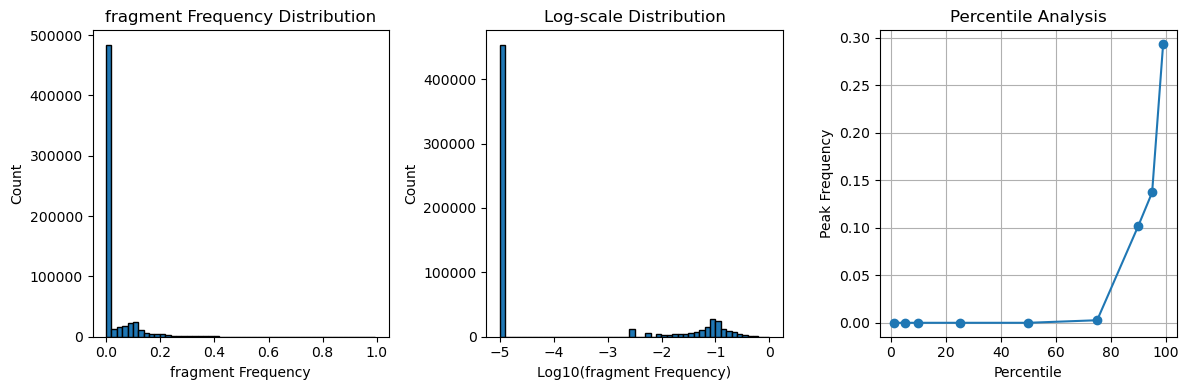

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.hist(peak_freq, bins=50, edgecolor='black')
plt.xlabel('fragment Frequency')
plt.ylabel('Count')
plt.title('fragment Frequency Distribution')

plt.subplot(132)
plt.hist(np.log10(peak_freq + 1e-5), bins=50, edgecolor='black')
plt.xlabel('Log10(fragment Frequency)')
plt.ylabel('Count')
plt.title('Log-scale Distribution')

plt.subplot(133)
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
values = np.percentile(peak_freq, percentiles)
plt.plot(percentiles, values, 'o-')
plt.xlabel('Percentile')
plt.ylabel('Peak Frequency')
plt.title('Percentile Analysis')
plt.grid(True)

plt.tight_layout()
plt.savefig('peak_frequency_analysis.png', dpi=150)

In [ ]:
min_freq_A = 0.03  # ~11 cells
max_freq_A = 0.95  # ~354 cells

# Recommended configuration B (conservative)
min_freq_B = 0.05  # ~19 cells  
max_freq_B = 0.95  # ~354 cells

# Recommended configuration C (aggressive, more features)
min_freq_C = 0.01  # ~4 cells
max_freq_C = 0.98  # ~365 cells

configs = [
    ('A', min_freq_A, max_freq_A),
    ('B', min_freq_B, max_freq_B),
    ('C', min_freq_C, max_freq_C)
]

print(f'\ndifferent filtering method:')
for name, min_f, max_f in configs:
    mask = (peak_freq >= min_f) & (peak_freq <= max_f)
    n_keep = mask.sum()
    print(f'  {name:15s}: [{min_f:.2f}, {max_f:.2f}] -> keep {n_keep:6d} peaks ({n_keep/n_peaks*100:.1f}%)')



不同过滤策略比较:
  A-平衡(推荐)       : [0.03, 0.95] -> 保留 126728 peaks (20.5%)
  B-保守           : [0.05, 0.95] -> 保留 114097 peaks (18.5%)
  C-激进           : [0.01, 0.98] -> 保留 143409 peaks (23.2%)


In [ ]:
min_freq = 0.05  # ~19 cells  
max_freq = 0.95  # ~354 cells

freq_mask = (peak_freq >= min_freq) & (peak_freq <= max_freq)
binary_matrix = binary_matrix[freq_mask]
peak_names = [p for p, keep in zip(peak_names, freq_mask) if keep]
peak_freq = peak_freq[freq_mask]

print(f'\nDone: using B save {binary_matrix.shape[0]} peaks')


✓ 使用配置 B，保留 114097 peaks


In [ ]:
cell_counts = np.array(binary_matrix.sum(axis=0)).flatten()

print(f'\nCell statistics:')
print(f'  every cell fragment number:')
print(f'    minimum: {cell_counts.min():.0f}')
print(f'    maximum: {cell_counts.max():.0f}')
print(f'    mean: {cell_counts.mean():.0f}')
print(f'    median: {np.median(cell_counts):.0f}')


Cell statistics:
  every cell peak number:
    minimum: 3088
    maximum: 61655
    mean: 14975
    median: 9580


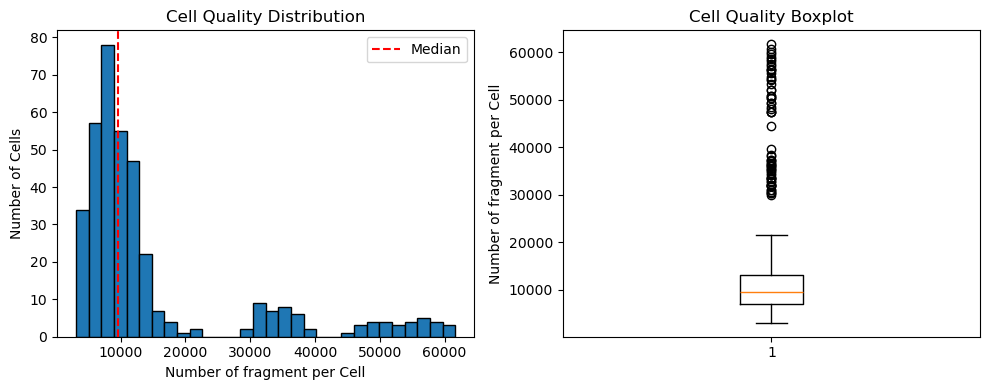

In [11]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.hist(cell_counts, bins=30, edgecolor='black')
plt.xlabel('Number of fragment per Cell')
plt.ylabel('Number of Cells')
plt.title('Cell Quality Distribution')
plt.axvline(np.median(cell_counts), color='red', linestyle='--', label='Median')
plt.legend()

plt.subplot(122)
plt.boxplot(cell_counts, vert=True)
plt.ylabel('Number of fragment per Cell')
plt.title('Cell Quality Boxplot')

plt.tight_layout()

In [12]:

max_peaks_per_cell = 25000
valid_cells = cell_counts <= max_peaks_per_cell
 
binary_matrix = binary_matrix[:, valid_cells]
cell_names = [c for c, v in zip(cell_names, valid_cells) if v]

print(f'\nDone: after filtering: {binary_matrix.shape[0]} fragment x {binary_matrix.shape[1]} cells')
print(f'  remove {n_cells - binary_matrix.shape[1]} cells')



✓ after filtering: 114097 fragment × 307 cells
  remove 65 cells


In [13]:
binary_matrix.shape

(114097, 307)

In [14]:
n_peaks_after_filter = binary_matrix.shape[0]

if n_peaks_after_filter > 20000:
    # If there are too many peaks, keep the highest-variance subset
    n_top_peaks = 15000
    print(f'\nPeaks too many selecting features...')
    
    # Compute variance for each peak
    peak_vars = np.var(binary_matrix.toarray(), axis=1)
    top_indices = np.argsort(peak_vars)[-n_top_peaks:]
    
    binary_matrix = binary_matrix[top_indices]
    peak_names = [peak_names[i] for i in top_indices]
    
    print(f'Done: selected top {n_top_peaks} high-variance peaks')
    
elif n_peaks_after_filter > 50000:
    # With extremely many peaks, fall back to a more aggressive strategy
    n_top_peaks = 10000
    print(f'\nPeaks extremely abundant - perform aggressive feature selection...')
    
    # First filter down to 30k peaks by variance
    peak_vars = np.var(binary_matrix.toarray(), axis=1)
    top_30k = np.argsort(peak_vars)[-30000:]
    binary_matrix_30k = binary_matrix[top_30k]
    
    # Then use PCA/variance ratio to select the final 10k peaks
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=50)
    svd.fit(binary_matrix_30k.T.toarray())
    
    # Evaluate each peak importance across the first 50 PCs
    peak_importance = np.sum(np.abs(svd.components_), axis=0)
    final_indices = np.argsort(peak_importance)[-n_top_peaks:]
    
    global_indices = top_30k[final_indices]
    binary_matrix = binary_matrix[global_indices]
    peak_names = [peak_names[i] for i in global_indices]
    
    print(f'Done: Use PCA-based method to select {n_top_peaks} peaks')
else:
    print(f'\nPeaks count acceptable, keep all {n_peaks_after_filter} peaks')

print(f'\nCurrent matrix:: {binary_matrix.shape[0]} peaks x {binary_matrix.shape[1]} cells')


Peaks 过多，进行特征选择...
✓ 选择了 top 15000 个高方差 peaks

当前数据: 15000 peaks × 307 cells


In [ ]:
print(f'\nCurrent matrix: {binary_matrix.shape[0]} peaks x {binary_matrix.shape[1]} cells')


当前数据: 15000 peaks × 307 cells


In [16]:


cell_totals = np.array(binary_matrix.sum(axis=0)).flatten()

In [17]:
print(f'\neach cell fragment number:')
print(f'  minimum: {cell_totals.min():.0f}')
print(f'  maximum: {cell_totals.max():.0f}')
print(f'  mean: {cell_totals.mean():.0f}')
print(f'  median: {np.median(cell_totals):.0f}')
print(f'  sd: {cell_totals.std():.0f}')


each cell fragment number:
  minimum: 1366
  maximum: 6597
  mean: 3738
  median: 3698
  sd: 1088


In [18]:
cv = cell_totals.std() / cell_totals.mean()
print(f'  (CV): {cv:.3f}')

  (CV): 0.291


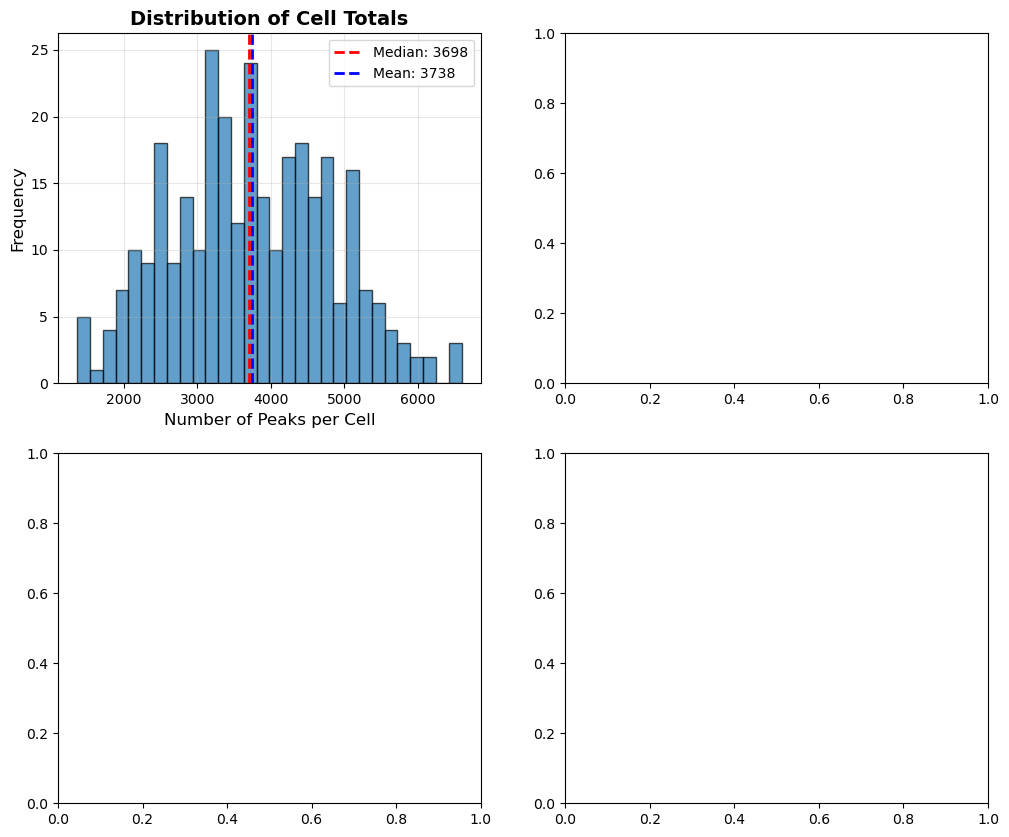

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1: histogram
axes[0, 0].hist(cell_totals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.median(cell_totals), color='red', linestyle='--', 
                    linewidth=2, label=f'Median: {np.median(cell_totals):.0f}')
axes[0, 0].axvline(cell_totals.mean(), color='blue', linestyle='--', 
                    linewidth=2, label=f'Mean: {cell_totals.mean():.0f}')
axes[0, 0].set_xlabel('Number of Peaks per Cell', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Cell Totals', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

In [20]:
q1 = np.percentile(cell_totals, 25)
q3 = np.percentile(cell_totals, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers_mask = (cell_totals < lower_bound) | (cell_totals > upper_bound)
n_outliers = outliers_mask.sum()

print(f'\nOutlier detection (IQR method):')
print(f'  Q1 (25%): {q1:.0f}')
print(f'  Q3 (75%): {q3:.0f}')
print(f'  IQR: {iqr:.0f}')
print(f'  Lower bound: {lower_bound:.0f}')
print(f'  Upper bound: {upper_bound:.0f}')
print(f'  Number of outlier cells: {n_outliers} / {len(cell_totals)} ({n_outliers/len(cell_totals)*100:.1f}%)')

if n_outliers > 0:
    print(f'\nWarning:  Detected {n_outliers}  outlier cells!')
    print(f'  Option 1: filter these outlier cells(recommended)')
    print(f'  Option 2: apply normalization to alleviate differences')
    
    # Show indices of outlier cells
    outlier_indices = np.where(outliers_mask)[0]
    print(f'  outliercellsindices: {outlier_indices[:10]}...' if len(outlier_indices) > 10 
          else f'  outliercellsindices: {outlier_indices}')


异常值检测 (IQR 方法):
  Q1 (25%): 2943
  Q3 (75%): 4529
  IQR: 1586
  下界: 564
  上界: 6908
  异常细胞数: 0 / 307 (0.0%)


In [21]:
print('=' * 60)
print(f'Step 9: MinMax Scaling to [0, 1]')
print('=' * 60)

print(f'Before scaling:')
print(f'  Value range: [{binary_matrix.min():.4f}, {binary_matrix.max():.4f}]')
mean_before = binary_matrix.mean()
std_before = np.sqrt(max(binary_matrix.power(2).mean() - mean_before**2, 0))
print(f'  Mean: {mean_before:.4f}')
print(f'  Std dev: {std_before:.4f}')

# SCALEX uses MaxAbsScaler
# Each peak is scaled independently to [-1, 1]; values are non-negative so the range becomes [0, 1]
scaler = MaxAbsScaler()

# Important: scale along the peak axis (columns), so transpose temporarily
# Input shape: (cells, peaks)
# Output shape: (cells, peaks)
final_matrix = scaler.fit_transform(binary_matrix.T).T

print(f'After scaling:')
print(f'  Value range: [{final_matrix.min():.4f}, {final_matrix.max():.4f}]')
mean_after = final_matrix.mean()
std_after = np.sqrt(max(final_matrix.power(2).mean() - mean_after**2, 0))
print(f'  Mean: {mean_after:.4f}')
print(f'  Std dev: {std_after:.4f}')


Step 9: MinMax 缩放到 [0, 1]
缩放前:
  数值范围: [0.0000, 1.0000]
  均值: 0.2492
  标准差: 0.4326
缩放后:
  数值范围: [0.0000, 1.0000]
  均值: 0.2492
  标准差: 0.4326


In [22]:
assert final_matrix.min() >= 0 and final_matrix.max() <= 1, "Scaling failed! Value exceeds [0, 1] range"
print(f'\nDone: MinMax Scalingcompleted values in [0, 1] range')


✅ MinMax 缩放完成，数据在 [0, 1] 范围内


In [23]:
print('=' * 60)
print('Step 10: Final data quality check')
print('=' * 60)

# Basic statistics
print('[Stats] Dimensions:')
n_peaks, n_cells = final_matrix.shape
total_elements = n_peaks * n_cells
print(f'  Shape: {n_peaks} peaks x {n_cells} cells')
print(f'  Total elements: {total_elements:,}')

if hasattr(final_matrix, 'data'):
    bytes_used = (final_matrix.data.nbytes +
                  final_matrix.indices.nbytes +
                  final_matrix.indptr.nbytes)
    print(f'  Approx memory usage (approx): {bytes_used / 1024**2:.2f} MB')
else:
    dense_arr = np.asarray(final_matrix)
    print(f'  Approx memory usage: {dense_arr.nbytes / 1024**2:.2f} MB')

print('[Stats] Value statistics:')
mean_val = float(final_matrix.mean())
if hasattr(final_matrix, 'power'):
    sq_mean = float(final_matrix.power(2).mean())
else:
    sq_mean = float((final_matrix ** 2).mean())
std_val = np.sqrt(max(sq_mean - mean_val**2, 0.0))
min_val = float(final_matrix.min())
max_val = float(final_matrix.max())

if hasattr(final_matrix, 'nnz'):
    nnz = final_matrix.nnz
else:
    nnz = int(np.count_nonzero(final_matrix))
num_zeros = total_elements - nnz

if hasattr(final_matrix, 'data'):
    nonzero_data = np.sort(final_matrix.data) if nnz > 0 else np.array([])
    def value_at(index):
        if index < num_zeros:
            return 0.0
        return float(nonzero_data[index - num_zeros])
    if total_elements % 2 == 1:
        median_val = value_at(total_elements // 2)
    else:
        lower = value_at(total_elements // 2 - 1)
        upper = value_at(total_elements // 2)
        median_val = 0.5 * (lower + upper)
else:
    median_val = float(np.median(final_matrix))

print(f'  Min: {min_val:.6f}')
print(f'  Max: {max_val:.6f}')
print(f'  Mean: {mean_val:.6f}')
print(f'  Median: {median_val:.6f}')
print(f'  Std dev: {std_val:.6f}')

print('[Stats] Sparsity:')
nonzero_ratio = nnz / total_elements if total_elements > 0 else 0.0
zero_ratio = 1.0 - nonzero_ratio
print(f'  Zero fraction: {zero_ratio:.2%}')
print(f'  Non-zero fraction: {nonzero_ratio:.2%}')

if hasattr(final_matrix, 'getnnz'):
    avg_nonzero_per_cell = final_matrix.getnnz(axis=0).mean()
    avg_nonzero_per_peak = final_matrix.getnnz(axis=1).mean()
else:
    avg_nonzero_per_cell = (final_matrix > 0).sum(axis=0).mean()
    avg_nonzero_per_peak = (final_matrix > 0).sum(axis=1).mean()

print(f'  Avg non-zero peaks per cell: {avg_nonzero_per_cell:.0f}')
print(f'  Avg non-zero cells per peak: {avg_nonzero_per_peak:.0f}')


Step 10: 最终数据质量检查
📊 维度信息:
  形状: 15000 peaks × 307 cells
  总元素数: 4,605,000
  内存占用 (approx): 8.81 MB
📊 数值统计:
  最小值: 0.000000
  最大值: 1.000000
  均值: 0.249221
  中位数: 0.000000
  标准差: 0.432562
📊 稀疏度:
  零值比例: 75.08%
  非零比例: 24.92%
  平均每个细胞的非零 peaks: 3738
  平均每个 peak 的非零细胞: 77


In [24]:
print('\n[Stats] Every cell statistics:')
if hasattr(final_matrix, 'getnnz'):
    cell_nonzeros = np.asarray(final_matrix.getnnz(axis=0)).ravel()
else:
    cell_nonzeros = np.count_nonzero(np.asarray(final_matrix), axis=0)
cell_means = np.asarray(final_matrix.mean(axis=0)).ravel()
if hasattr(final_matrix, 'power'):
    cell_sq_means = np.asarray(final_matrix.power(2).mean(axis=0)).ravel()
else:
    cell_sq_means = np.asarray((np.asarray(final_matrix) ** 2).mean(axis=0)).ravel()
cell_stds = np.sqrt(np.clip(cell_sq_means - cell_means**2, a_min=0.0, a_max=None))
print(f'  non-zero fragment: [{cell_nonzeros.min():.0f}, {cell_nonzeros.max():.0f}]')
print(f'  mean: [{cell_means.min():.4f}, {cell_means.max():.4f}]')
print(f'  SD: [{cell_stds.min():.4f}, {cell_stds.max():.4f}]')

print('\n[Stats] every fragment statistics:')
if hasattr(final_matrix, 'getnnz'):
    peak_nonzeros = np.asarray(final_matrix.getnnz(axis=1)).ravel()
else:
    peak_nonzeros = np.count_nonzero(np.asarray(final_matrix), axis=1)
peak_means = np.asarray(final_matrix.mean(axis=1)).ravel()
if hasattr(final_matrix, 'power'):
    peak_sq_means = np.asarray(final_matrix.power(2).mean(axis=1)).ravel()
else:
    peak_sq_means = np.asarray((np.asarray(final_matrix) ** 2).mean(axis=1)).ravel()
peak_stds = np.sqrt(np.clip(peak_sq_means - peak_means**2, a_min=0.0, a_max=None))
print(f'  non-zero cell: [{peak_nonzeros.min():.0f}, {peak_nonzeros.max():.0f}]')
print(f'  mean: [{peak_means.min():.4f}, {peak_means.max():.4f}]')
print(f'  SD: [{peak_stds.min():.4f}, {peak_stds.max():.4f}]')


print('\n[Check] outliers check:')
if hasattr(final_matrix, 'data'):
    data = final_matrix.data
    has_nan = np.isnan(data).any()
    has_inf = np.isinf(data).any()
else:
    arr = np.asarray(final_matrix)
    has_nan = np.isnan(arr).any()
    has_inf = np.isinf(arr).any()
print(f"  Include NaN: {'WARNING' if has_nan else 'OK: no'}")
print(f"  Include Inf: {'WARNING' if has_inf else 'OK: no'}")



📊 Every cell statistics:
  non-zero fragment: [1366, 6597]
  mean: [0.0911, 0.4398]
  SD: [0.2877, 0.4964]

📊 every fragment statistics:
  non-zero cell: [46, 260]
  mean: [0.1498, 0.8469]
  SD: [0.3569, 0.5000]

🔍 outliers check:
  include NaN: ✅ NO
  include Inf: ✅ NO


In [27]:
print("Saving as sparse .npz matrix...")
sparse.save_npz('preprocessed_cutntag_final2.npz', final_matrix)

# 2. Use os.path.getsize to report on-disk file size
file_size_mb = os.path.getsize('preprocessed_cutntag_final2.npz') / 1024**2
print(f'\nDone: Saved: preprocessed_cutntag_final2.npz ({file_size_mb:.2f} MB)')

# 3. Metadata export code remains unchanged
with open('filtered_cells_final2.txt', 'w') as f:
    f.write('\n'.join(cell_names))
print(f'Done: Saved: filtered_cells_final2.txt ({len(cell_names)} cells)')

with open('filtered_peaks_final2.txt', 'w') as f:
    f.write('\n'.join(peak_names))
print(f'Done: Saved: filtered_peaks_final2.txt ({len(peak_names)} peaks)')

Saving as sparse .npz matrix...

✅ 已保存: preprocessed_cutntag_final2.npz (0.96 MB)
✅ 已保存: filtered_cells_final2.txt (307 cells)
✅ 已保存: filtered_peaks_final2.txt (15000 peaks)
